##### Copyright 2018 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Image classification

<table class="tfo-notebook-buttons" align="left">
  <td>     <a target="_blank" href="https://www.tensorflow.org/tutorials/images/classification"><img src="https://www.tensorflow.org/images/tf_logo_32px.png">TensorFlow.org で表示</a> </td>
  <td>     <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ja/tutorials/images/classification.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Google Colab で実行</a> </td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ja/tutorials/images/classification.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png"> GitHub でソースを表示</a></td>
  <td>     <a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ja/tutorials/images/classification.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">ノートブックをダウンロード</a> </td>
</table>

このチュートリアルでは、`tf.keras.Sequential` モデルを使用して花の画像を分類し、`tf.keras.utils.image_dataset_from_directory` を使用してデータを読み込む方法を示します。このチュートリアルでは、次の概念を実際に見ていきます。

- ディスク上のデータセットを効率的に読み込みます。
- 過学習を識別し、データ拡張やドロップアウトなどテクニックを使用して過学習を防ぎます。

このチュートリアルは、基本的な機械学習のワークフローに従います。

1. データの調査及び理解
2. 入力パイプラインの構築
3. モデルの構築
4. モデルの学習
5. モデルのテスト
6. モデルの改善とプロセスの繰り返し

さらに、このノートブックは、[保存されたモデル](../../../guide/saved_model.ipynb)を、モバイルデバイス、組み込みデバイス、IoT デバイスでのオンデバイス機械学習用の [TensorFlow Lite](https://www.tensorflow.org/lite/) モデルに変換する方法を実演します。

## セットアップ

TensorFlow とその他の必要なライブラリをインポートします。

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## データセットをダウンロードして調査する

このチュートリアルでは、約3,700枚の花の写真のデータセットを使用します。データセットには、クラスごとに1つずつ、5 つのサブディレクトリが含まれています。

```
flower_photo/
  daisy/
  dandelion/
  roses/
  sunflowers/
  tulips/
```

In [3]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

228813984/228813984 [==============================] - 6s 0us/step


ダウンロード後、データセットのコピーが利用できるようになります。合計3,670枚の画像があります。

In [4]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


バラの画像です。

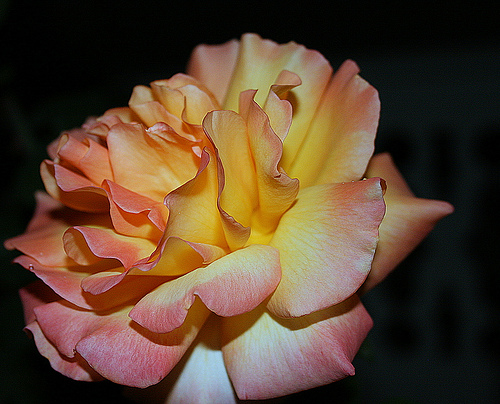

In [5]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

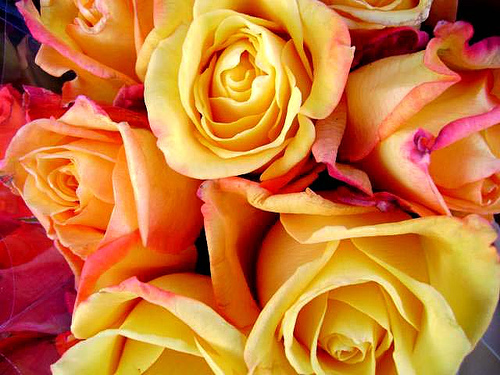

In [6]:
PIL.Image.open(str(roses[1]))

チューリップの画像です。

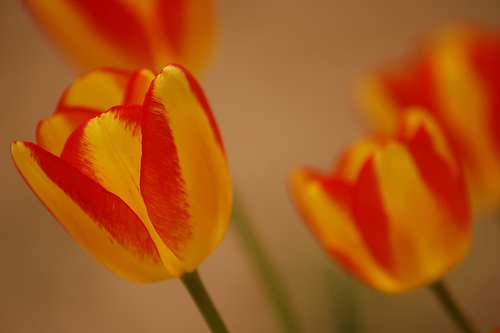

In [7]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))

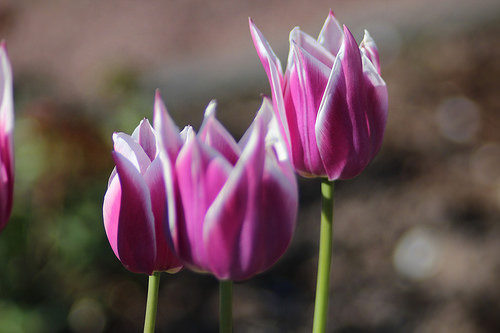

In [8]:
PIL.Image.open(str(tulips[1]))

## Keras ユーティリティを使用してデータを読み込む

次に、便利な <a>image_dataset_from_directory</a> ユーティリティを使用して、これらの画像をディスクから読み込みます。これにより、数行のコードでディスク上の画像のディレクトリから `tf.data.Dataset`に移動します。また、[画像を読み込んで前処理する](../load_data/images.ipynb)チュートリアルにアクセスして、独自のデータ読み込みコードを最初から作成することもできます。

### データセットを作成する

ローダーのいくつかのパラメーターを定義します。

In [9]:
batch_size = 32
img_height = 180
img_width = 180

モデルを開発するときは、検証分割を使用することをお勧めします。ここでは、画像の 80％ をトレーニングに使用し、20％ を検証に使用します。

In [10]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [11]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


クラス名は、これらのデータセットの`class_names`属性にあります。 これらはアルファベット順にディレクトリ名に対応します。

In [12]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


## データを視覚化する

以下はトレーニングデータセットの最初の 9 枚の画像です。

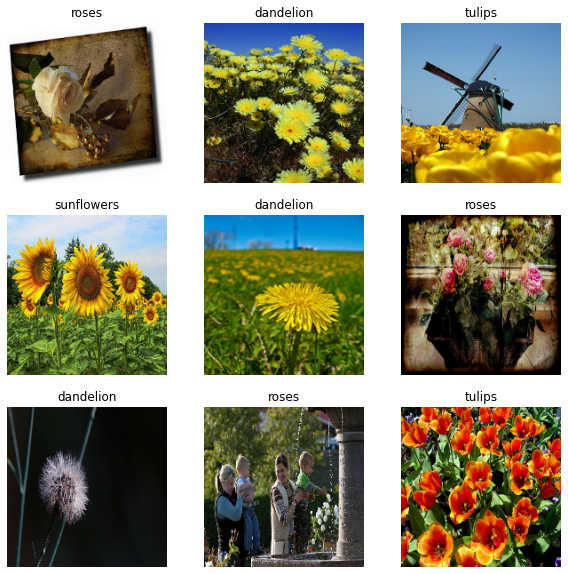

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

これらのデータセットを Keras `Model.fit` に渡すことで、モデルをトレーニングできます（このチュートリアルの後の方で説明しています）。また、手動でデータセットを反復し、画像のバッチを取得することもできます。

In [14]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


`image_batch`は、形状`(32, 180, 180, 3)`のテンソルです。これは、形状`180x180x3`の 32 枚の画像のバッチです（最後の次元はカラーチャンネル RGB を参照します）。`label_batch`は、形状`(32,)`のテンソルであり、これらは 32 枚の画像に対応するラベルです。

`image_batch`および`labels_batch`テンソルで`.numpy()`を呼び出して、それらを`numpy.ndarray`に変換できます。


## データセットを構成してパフォーマンスを改善する

I/O がブロックされることなくディスクからデータを取得できるように、必ずバッファ付きプリフェッチを使用します。これらは、データを読み込むときに使用する必要がある 2 つの重要な方法です。

- `Dataset.cache()`は、最初のエポック中に画像をディスクから読み込んだ後、メモリに保持します。これにより、モデルのトレーニング中にデータセットがボトルネックになることを回避できます。データセットが大きすぎてメモリに収まらない場合は、この方法を使用して、パフォーマンスの高いオンディスクキャッシュを作成することもできます。
- `Dataset.prefetch` はトレーニング中にデータの前処理とモデルの実行をオーバーラップさせます。

以上の 2 つの方法とデータをディスクにキャッシュする方法についての詳細は、<a>データパフォーマンスガイド</a>の <em>プリフェッチ</em>を参照してください。

In [15]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## データを標準化する

RGB チャネル値は `[0, 255]` の範囲にあり、ニューラルネットワークには理想的ではありません。一般に、入力値は小さくする必要があります。

ここでは、`tf.keras.layers.Rescaling` を使用して、値を `[0, 1]` の範囲に標準化します。

In [16]:
normalization_layer = layers.Rescaling(1./255)

このレイヤーを使用するには 2 つの方法があります。`Dataset.map` を呼び出すことにより、データセットに適用できます。

In [17]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


または、モデル定義内にレイヤーを含めることができます。これにより、デプロイメントを簡素化できます。 ここでは 2 番目のアプローチを使用します。

注意: 以前は、`tf.keras.utils.image_dataset_from_directory` の `image_size` 引数を使用して画像のサイズを変更しました。モデルにサイズ変更ロジックも含める場合は、`tf.keras.layers.Resizing` レイヤーを使用できます。

## 基本的な Keras モデル

### モデルを作成する

[Sequential](https://www.tensorflow.org/guide/keras/sequential_model) モデルは、それぞれに最大プールレイヤー （`tf.keras.layers.MaxPooling2D`）を持つ 3 つの畳み込みブロック（`tf.keras.layers.Conv2D`）で構成されます。ReLU 活性化関数（`'relu'`）により活性化されたユニットが 128 個ある完全に接続されたレイヤー （`tf.keras.layers.Dense`）があります。このチュートリアルの目的は、標準的なアプローチを示すことなので、このモデルは高精度に調整されていません。

In [18]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

### モデルをコンパイルする

このチュートリアルでは、`tf.keras.optimizers.Adam` オプティマイザと`tf.keras.losses.SparseCategoricalCrossentropy` 損失関数を選択します。各トレーニングエポックのトレーニングと検証の精度を表示するには、`Model.compile` に `metrics` 引数を渡します。

In [19]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### モデルの概要

Keras の `Model.summary` メソッドを使用して、ネットワークのすべてのレイヤーを表示します。

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

### モデルをトレーニングする

Keras `Model.fit` メソッドを使用して、10 エポックのモデルをトレーニングします。

In [21]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
92/92 [==============================] - 12s 39ms/step - loss: 1.3230 - accuracy: 0.4353 - val_loss: 1.0928 - val_accuracy: 0.5545
Epoch 2/10
92/92 [==============================] - 2s 24ms/step - loss: 1.0136 - accuracy: 0.5957 - val_loss: 0.9960 - val_accuracy: 0.5777
Epoch 3/10
92/92 [==============================] - 2s 24ms/step - loss: 0.8164 - accuracy: 0.6935 - val_loss: 0.9154 - val_accuracy: 0.6458
Epoch 4/10
92/92 [==============================] - 2s 24ms/step - loss: 0.6060 - accuracy: 0.7704 - val_loss: 0.9648 - val_accuracy: 0.6390
Epoch 5/10
92/92 [==============================] - 2s 24ms/step - loss: 0.4173 - accuracy: 0.8549 - val_loss: 1.0822 - val_accuracy: 0.6471
Epoch 6/10
92/92 [==============================] - 2s 24ms/step - loss: 0.2421 - accuracy: 0.9237 - val_loss: 1.1821 - val_accuracy: 0.6594
Epoch 7/10
92/92 [==============================] - 2s 24ms/step - loss: 0.1468 - accuracy: 0.9591 - val_loss: 1.4297 - val_accuracy: 0.6580
Epoch 8/10
9

## トレーニングの結果を視覚化する

トレーニングセットと検証セットで損失と精度のプロットを作成します。

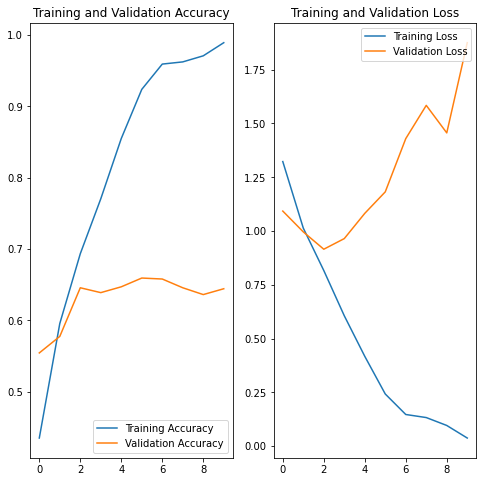

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

プロットには、トレーニングの精度と検証の精度は大幅にずれており、モデルは検証セットで約 60％ の精度しか達成していないことが示されています。

以下のチュートリアルセクションでは、問題の原因を調べ、モデルの全体的なパフォーマンスを向上させる方法を示します。

## 過学習

上記のプロットでは、トレーニングの精度は時間の経過とともに直線的に増加していますが、検証の精度はトレーニングプロセスで約60％のままです。また、トレーニングと検証の精度に大きな違いがあり、これは[過学習](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit)の兆候を示しています。

トレーニングサンプルの数が少ない場合、モデルは、トレーニングサンプルのノイズや不要な詳細から学習し、新しいサンプルでのモデルのパフォーマンスに悪影響を及ぼすことがあります。 この現象は過学習として知られています。 これは、モデルが新しいデータセットで一般化する上で問題があることを意味します。

トレーニングプロセスで過学習を回避する方法は複数あります。このチュートリアルでは、*データ拡張*を使用して、モデルに*ドロップアウト*を追加します。

## データ拡張

過学習は、一般に、トレーニングサンプルの数が少ない場合に発生します。[データ拡張](./data_augmentation.ipynb)は、既存のサンプルに対してランダムな変換を使用してサンプルを拡張することにより、追加のトレーニングデータを生成します。これにより、モデルをデータのより多くの側面でトレーニングし、より一般化することができます。

`tf.keras.layers.RandomFlip`、`tf.keras.layers.RandomRotation`、および `tf.keras.layers.RandomZoom` の前処理レイヤーを使用して、データ拡張を実装します。これらは、他のレイヤーと同様にモデル内に含めて、GPU で実行できます。

In [23]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

同じ画像にデータ拡張を数回適用して、いくつかの拡張されたデータがどのようになるかを視覚化してみましょう。

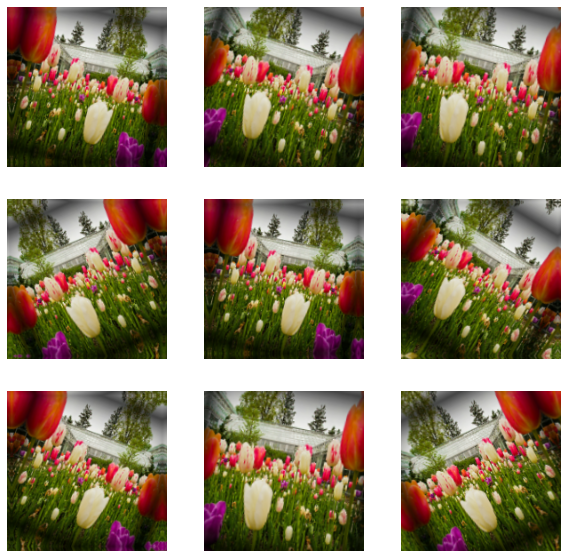

In [24]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

次のステップでトレーニングする前に、モデルにデータ拡張を追加します。

## ドロップアウト

過学習を回避するもう 1 つの方法は、[ドロップアウト](https://developers.google.com/machine-learning/glossary#dropout_regularization){:.external} 正則化をネットワークに導入することです。

ドロップアウトをレイヤーに適用すると、トレーニングプロセス中にレイヤーからいくつかの出力ユニットがランダムにドロップアウトされます（アクティベーションをゼロに設定することにより）。ドロップアウトは、0.1、0.2、0.4 などの形式で、入力値として小数を取ります。これは、適用されたレイヤーから出力ユニットの 10％、20％、または 40％ をランダムにドロップアウトすることを意味します。

拡張された画像を使用してトレーニングする前に、`tf.keras.layers.Dropout` を使用して新しいニューラルネットワークを作成します。

In [25]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

## モデルをコンパイルしてトレーニングする

In [26]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [27]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [28]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
92/92 [==============================] - 5s 42ms/step - loss: 1.2929 - accuracy: 0.4458 - val_loss: 1.1039 - val_accuracy: 0.5599
Epoch 2/15
92/92 [==============================] - 4s 41ms/step - loss: 1.0409 - accuracy: 0.5971 - val_loss: 0.9996 - val_accuracy: 0.6185
Epoch 3/15
92/92 [==============================] - 4s 40ms/step - loss: 0.9389 - accuracy: 0.6349 - val_loss: 0.9039 - val_accuracy: 0.6390
Epoch 4/15
92/92 [==============================] - 4s 40ms/step - loss: 0.8712 - accuracy: 0.6638 - val_loss: 0.8834 - val_accuracy: 0.6471
Epoch 5/15
92/92 [==============================] - 5s 58ms/step - loss: 0.8113 - accuracy: 0.6853 - val_loss: 0.8406 - val_accuracy: 0.6567
Epoch 6/15
92/92 [==============================] - 4s 40ms/step - loss: 0.7620 - accuracy: 0.7142 - val_loss: 0.7949 - val_accuracy: 0.6730
Epoch 7/15
92/92 [==============================] - 4s 40ms/step - loss: 0.7290 - accuracy: 0.7268 - val_loss: 0.8004 - val_accuracy: 0.6757
Epoch 8/15
92

## トレーニングの結果を視覚化する

データ拡張と `tf.keras.layers.Dropout` を適用した後は、以前よりも過学習が少なくなり、トレーニングと検証がより高精度に調整されます。

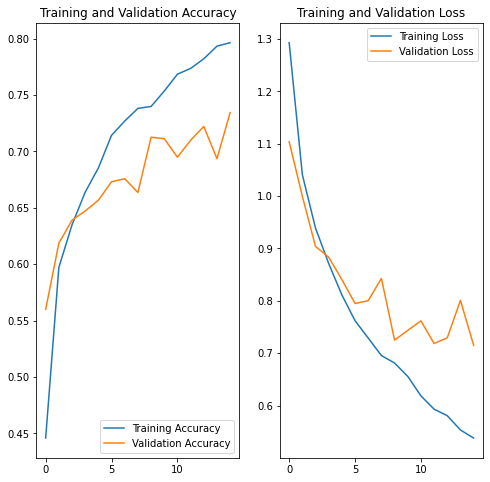

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## 新しいデータを予測する

モデルを使用して、トレーニングセットまたは検証セットに含まれていなかった画像を分類します。

注意: データ拡張レイヤーとドロップアウトレイヤーは、推論時に非アクティブになります。

In [30]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 145ms/step
This image most likely belongs to sunflowers with a 95.88 percent confidence.


## TensorFlow Lite を使用する

TensorFlow Lite は、オンデバイスの機械学習を可能にする一連のツールで、開発者がモバイルデバイス、組み込みデバイス、エッジデバイスでモデルを実行できるようにします。

### Keras Sequential モデルを TensorFlow Lite モデルに変換する

トレーニング済みのモデルをオンデバイスのアプリケーションで使用するには、まず [TensorFlow Lite](https://www.tensorflow.org/lite/) モデルと呼ばれる、より小さく効率的なモデル形式に[変換](https://www.tensorflow.org/lite/models/convert)します。

この例では、トレーニング済みの Keras Sequential モデルを取得し、`tf.lite.TFLiteConverter.from_keras_model` を使用して [TensorFlow Lite](https://www.tensorflow.org/lite/) モデルを生成します。

In [31]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

前のステップで保存した TensorFlow Lite モデルには、複数の関数シグネチャを含めることができます。Keras モデルコンバーター API は、デフォルトのシグネチャを自動的に使用します。詳細は [TensorFlow Lite シグネチャ](https://www.tensorflow.org/lite/guide/signatures)を参照してください。

### TensorFlow Lite モデルを実行する

`tf.lite.Interpreter` クラスを介して、Python で TensorFlow Lite の保存されたモデルシグネチャにアクセスできます。

`Interpreter` を使用してモデルを読み込みます。

In [32]:
TF_MODEL_FILE_PATH = 'model.tflite' # The default path to the saved TensorFlow Lite model

interpreter = tf.lite.Interpreter(model_path=TF_MODEL_FILE_PATH)

変換されたモデルからシグネチャを出力して、入力 (および出力) の名前を取得します。


In [33]:
interpreter.get_signature_list()

{'serving_default': {'inputs': ['sequential_1_input'], 'outputs': ['outputs']}}

この例では、`serving_default` という名前のデフォルトシグネチャが 1 つあります。さらに、`'inputs'` の名前は `'sequential_1_input'` であり、`'outputs'` の名前は `'outputs'` です。このチュートリアルで前に示したように、`Model.summary` を実行すると、これらの最初と最後の Keras レイヤー名を検索できます。

次のようにシグネチャ名を渡すことで、`tf.lite.Interpreter.get_signature_runner` を使用してサンプル画像で推論を実行し、読み込まれた TensorFlow モデルをテストできます。

In [34]:
classify_lite = interpreter.get_signature_runner('serving_default')
classify_lite

チュートリアルの前半で行ったように、TensorFlow Lite モデルを使用して、トレーニングセットまたは検証セットに含まれていない画像を分類できます。

画像は既にテンソル化され、`img_array` として保存されています。次に、読み込まれた TensorFlow Lite モデル （`predictions_lite`）の最初の引数 （`'inputs'` の名前）に渡し、ソフトマックス活性化を計算し、計算された確率が最も高いクラスの予測を出力します。

In [35]:
predictions_lite = classify_lite(sequential_1_input=img_array)['outputs']
score_lite = tf.nn.softmax(predictions_lite)

In [36]:
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score_lite)], 100 * np.max(score_lite))
)

This image most likely belongs to sunflowers with a 95.88 percent confidence.


Lite モデルが生成した予測は、元のモデルが生成した予測とほぼ同一になります。

In [37]:
print(np.max(np.abs(predictions - predictions_lite)))

1.9073486e-06


モデルは画像が 5 つのクラス、`'daisy'`、`'dandelion'`、`'roses'`、`'sunflowers'`、および `'tulips'` のうちヒマワリに属すると予測する必要があります。これは TensorFlow Lite 変換前と同じ結果です。


## 次のステップ

このチュートリアルでは、画像分類用のモデルをトレーニングしてテストし、オンデバイスのアプリケーション（画像分類アプリケーションなど）用の TensorFlow Lite 形式に変換し、Python API を使用して TensorFlow Lite モデルで推論を実行する方法を示しました。

TensorFlow Lite についての詳細は、[チュートリアル](https://www.tensorflow.org/lite/tutorials)と[ガイド](https://www.tensorflow.org/lite/guide)を参照してください。